<a href="https://colab.research.google.com/github/Milad-Abdollahi/PersonalProjects/blob/main/test_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split('.')[1]) >= 12, 'torch version should be 1.12+'
  assert int(torchvision.__version__.split('.')[1]) >= 13, 'torchvision version should be 0.13+'
  print(f'torch version: {torch.__version__}')
  print(f'torchvision version: {torchvision.__version__}')
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch 
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")


torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

try:
  import torchinfo.summary as summary
except:
  print('[INFO] torchinfo not found ... installing torchinfo')
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  #!rm -rf pytorch-deel-learning
  from going_modular.going_modular import data_setup, engine

[INFO] torchinfo not found ... installing torchinfo


In [ ]:
# device agnostic code ...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import os
import zipfile
from pathlib import Path
import requests

# creating path to data folder
data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'
zipfile_path = data_path / 'pizza_steak_sushi.zip'


# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
  print(f'{image_path} directory already exists')
else:
  print(f'\ndid not find {image_path}, creating {image_path}')
  image_path.mkdir(parents=True, exist_ok=True)

  # downloading pizza steak sushi data
  with open(zipfile_path, 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('\ndownloading pizza steak sushi data...')
    f.write(request.content)
  
  # unzipping the zip file to image_folder
  with zipfile.ZipFile(zipfile_path, 'r') as zipref:
    print(f'\nunzipping pizza steak sushi zipfile to {image_path}')
    zipref.extractall(image_path)

  # removing the zip file
  print(f'\nremoving the zip file from {zipfile_path}')
  os.remove(zipfile_path)






data/pizza_steak_sushi directory already exists


In [ ]:
# creating paths for train and test images
train_dir = Path('/content/data/pizza_steak_sushi/train')
test_dir = Path('/content/data/pizza_steak_sushi/train')

In [ ]:
# creating the necessary transform (should be done mannually in torchvision < 0.13)
manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [ ]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32,
                                                                               num_workers=os.cpu_count())

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5516ca9af0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# getting a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default is the best available option
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# creating transforms automatically using weights from the above cell
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# creating dataloaders this time using auto_transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5516c560d0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# OLD way: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # old method with pretrained = True

# new way: setting up model with pretrained weights and sending it to device(for torchvision 0.13+) 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default means best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        # col_names=['input_size']),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False


In [ ]:
# changing the output shape of the model from 1000 to 3
output_shape = len(class_names)

# recreating the classifier layer
model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=True),
                                       torch.nn.Linear(in_features=1280, 
                                                       out_features=output_shape,
                                                       bias=True)).to(device)
                                                       

In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        # col_names=['input_size']),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# defining a loss function and an optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
from math import e
from timeit import default_timer as timer
start_time = timer()

epochs = 5

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochs,
                       device=device)

end_time = timer()
training_time = end_time - start_time
print(f'total training time {training_time}')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0449 | train_acc: 0.3867 | test_loss: 0.8205 | test_acc: 0.8164
Epoch: 2 | train_loss: 0.9356 | train_acc: 0.6133 | test_loss: 0.6926 | test_acc: 0.8320
Epoch: 3 | train_loss: 0.7509 | train_acc: 0.7422 | test_loss: 0.6337 | test_acc: 0.9453
Epoch: 4 | train_loss: 0.6520 | train_acc: 0.9141 | test_loss: 0.5777 | test_acc: 0.9336
Epoch: 5 | train_loss: 0.6547 | train_acc: 0.7617 | test_loss: 0.5236 | test_acc: 0.9258
total training time 152.56363224899997


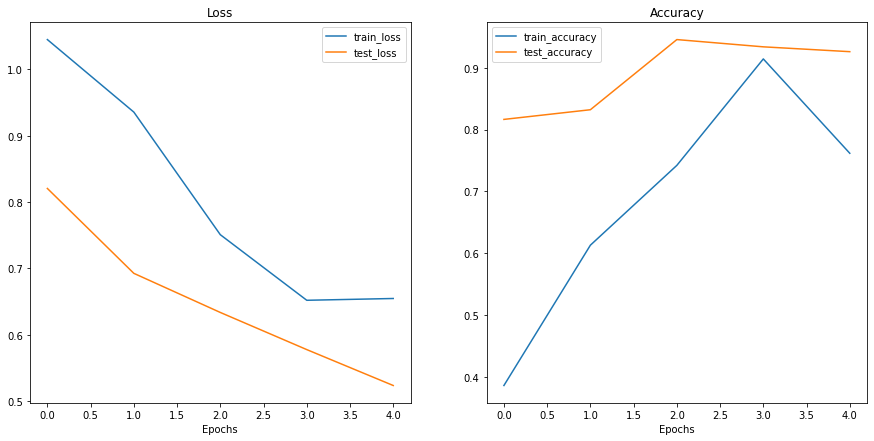

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
# defining a function to make predictions
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model:torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=224,
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
  # openning the image
  img = Image.open(image_path)

  # creating a transform if does not exists
  if transform:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                          ])
    
  # making a prediction on image
  model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)

    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
  plt.axis(False);


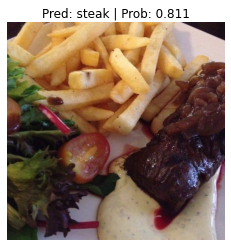

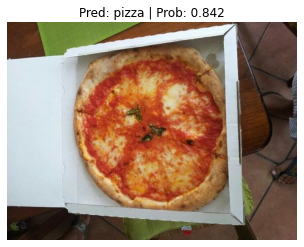

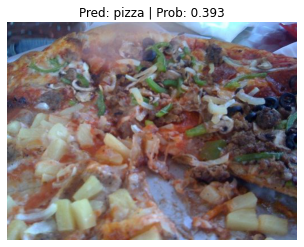

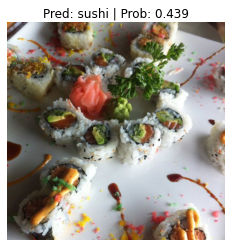

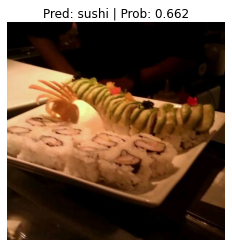

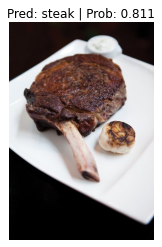

In [ ]:
import random
num_images_to_plot = 6
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

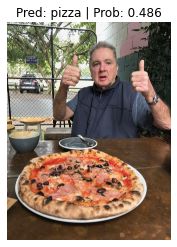

In [ ]:
# downloading custom dataset
import requests

# settin up custom image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# downloading the image
if custom_image_path.is_file():
  print(f'{custom_image_path} already exists ...')
else:
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)
 